In [32]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [33]:
df = pd.read_csv('Findata.csv')
df = df.dropna()
print(df.head())
print(df.describe().round(2))


   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
             step       amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
count  1048575.00   1048

In [34]:
label_encoders = {}
for col in ["type", "nameOrig", "nameDest"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print(df.head())

   step  type    amount  nameOrig  oldbalanceOrg  newbalanceOrig  nameDest  \
0     1     3   9839.64    125164       170136.0       160296.36    274917   
1     1     3   1864.28    361319        21249.0        19384.72    286716   
2     1     4    181.00    165236          181.0            0.00     73550   
3     1     1    181.00    961662          181.0            0.00     65464   
4     1     3  11668.14    567915        41554.0        29885.86    138001   

   oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0             0.0             0.0        0               0  
1             0.0             0.0        0               0  
2             0.0             0.0        1               0  
3         21182.0             0.0        1               0  
4             0.0             0.0        0               0  


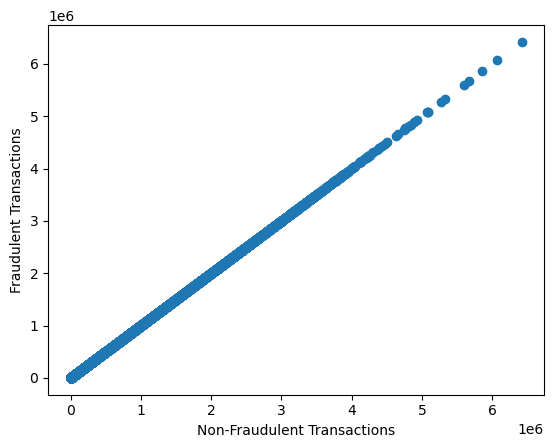

In [35]:
plt.scatter(x=df[df['isFraud'] == 0]['amount'], y=df[df['isFraud'] == 0]['amount'])
plt.xlabel('Non-Fraudulent Transactions')
plt.ylabel('Fraudulent Transactions')
plt.show()

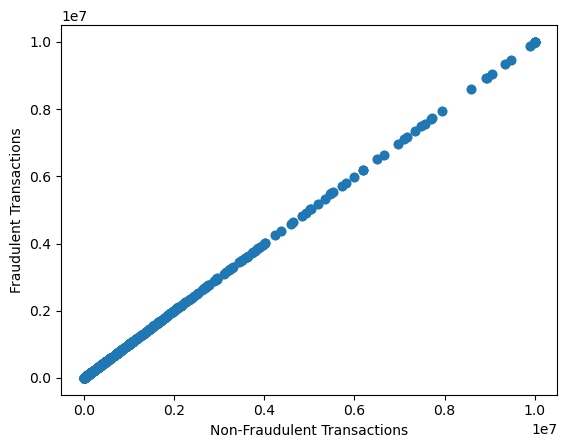

In [36]:
plt.scatter(x=df[df['isFraud'] == 1]['amount'], y=df[df['isFraud'] == 1]['amount'])
plt.xlabel('Non-Fraudulent Transactions')
plt.ylabel('Fraudulent Transactions')
plt.show()

In [37]:
X = df.drop(columns=["isFraud", "isFlaggedFraud"], errors='ignore')
y = df["isFraud"]


X.shape, y.shape


((1048575, 9), (1048575,))

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(838860, 9) (209715, 9) (838860,) (209715,)


In [39]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train), random_state=42)
clf_xgb.fit(X_train, y_train)

y_pred = clf_xgb.predict(X_test) 

print("supervised learning")
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))   

supervised learning
0.9996566769186753
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.84      0.85      0.84       228

    accuracy                           1.00    209715
   macro avg       0.92      0.93      0.92    209715
weighted avg       1.00      1.00      1.00    209715



In [9]:
#from sklearn.ensemble import RandomForestClassifier

#clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)

#print("Supervised Learning - Random Forest Classifier")
#print("Accuracy:", accuracy_score(y_test, y_pred))
#print(classification_report(y_test, y_pred))
# inconsistent results

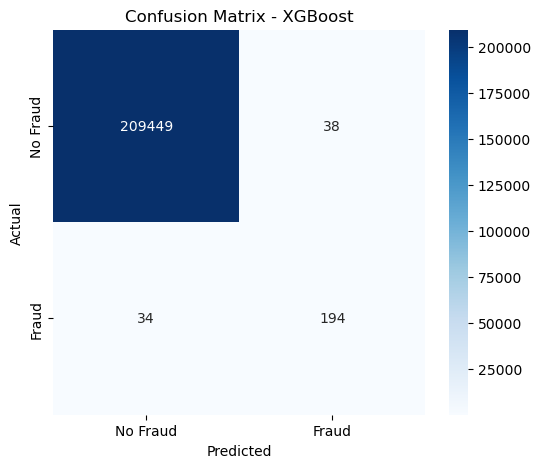

In [40]:
import seaborn as sns

plt.figure(figsize=(6,5))
cm_xgb = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

fraud_prediction
0    943717
1    104858
Name: count, dtype: int64


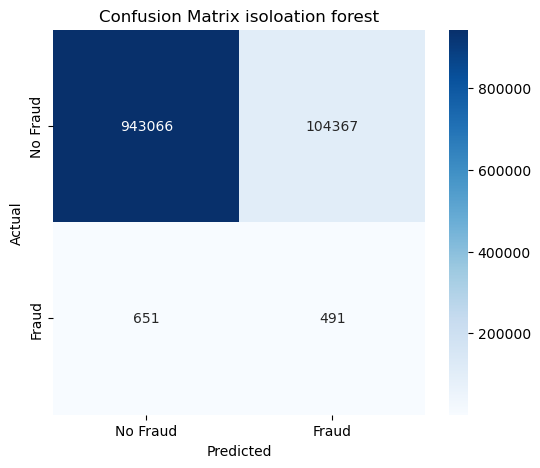

In [11]:
#unsupervised learning using isolation forest and dbscan to detect anomalies and cluster fraud transactions
from sklearn.ensemble import IsolationForest


iso_forest = IsolationForest(contamination=0.1, random_state=42)
df["fraud_prediction"] = iso_forest.fit_predict(X)
df["fraud_prediction"] = df["fraud_prediction"].apply(lambda x: 1 if x == -1 else 0)#0=normal, 1=fraud
    
print(df["fraud_prediction"].value_counts())


plt.figure(figsize=(6,5))
cm_iso = confusion_matrix(df["isFraud"], df["fraud_prediction"])
sns.heatmap(cm_iso, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix isoloation forest")
plt.show()




Cluster
-1    1048575
Name: count, dtype: int64


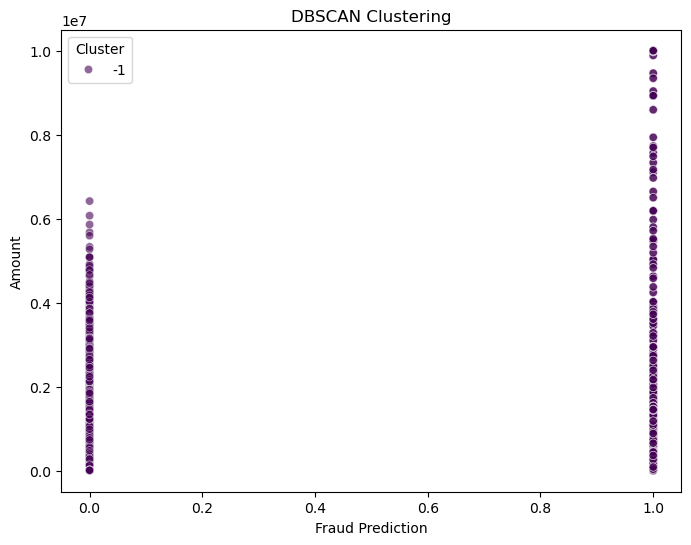

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
df['Cluster'] = dbscan.fit_predict(df.drop(columns=["isFraud", "isFlaggedFraud", "fraud_prediction"], errors='ignore'))





In [13]:
print(df.head())

   step  type    amount  nameOrig  oldbalanceOrg  newbalanceOrig  nameDest  \
0     1     3   9839.64    125164       170136.0       160296.36    274917   
1     1     3   1864.28    361319        21249.0        19384.72    286716   
2     1     4    181.00    165236          181.0            0.00     73550   
3     1     1    181.00    961662          181.0            0.00     65464   
4     1     3  11668.14    567915        41554.0        29885.86    138001   

   oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  fraud_prediction  \
0             0.0             0.0        0               0                 0   
1             0.0             0.0        0               0                 0   
2             0.0             0.0        1               0                 0   
3         21182.0             0.0        1               0                 0   
4             0.0             0.0        0               0                 0   

   Cluster  
0       -1  
1       -1  
2       -1 

In [ ]:
#df.to_csv('Traineddata.csv', index=False)


Model saved
